# Read files with PyTesseract
This notebook demonstrates the use of PyTesseract to read files containing both typed and handwritten text from the IAM Handwriting Database.

In [118]:
import cv2 
import pytesseract
import jiwer # Package used to calculate Word Error Rate (WER)
import matplotlib.pyplot as plt
import numpy as np
import os

In [64]:
img = cv2.imread('../formsA-D/a01-000u.png')  # Make sure to adjust the path to your specific file location

## Extract text with OCR
Applies OCR to extract the text using PyTesseract package.

In [65]:
custom_config = r'--oem 3 --psm 6'  # Define custom configuration options for Tesseract
# '--oem 3': Specifies the OCR Engine Mode (OEM). Option 3 allows Tesseract to use both the legacy and LSTM-based OCR engines.
# '--psm 6': Specifies the Page Segmentation Mode (PSM). Option 6 assumes the image contains a block of text and segments it accordingly.
extracted_text = pytesseract.image_to_string(img, config=custom_config)

In [66]:
print(extracted_text)

Sentence Database A01-000

“A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to.

' be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down

’ a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for

‘ Manchester Exchange.

: kh MOVE to stoe Mr. Garibledl from
pie Aowu a vesolrtiorn cour bhe_ A Qi2 ve
OnW Wo da VA_ backer by hur, Win



It is evident that the package works well when reading the typed text from the file, but it encounters significant issues with the handwritten text. Therefore, we need to fine-tune our code to achieve better results.

## Define evaluation metrics
Before tuning our model, we need to define metrics for OCR evaluation to track improvements. To do this, we will calculate the Word Error Rate (WER) using the jiwer package. Additionally, we need to ensure that we import the correct reference text, which we expect our package to detect, so that we can accurately compare the obtained results.

The Word Error Rate (WER) is calculated using the following formula:

$$
WER = \frac{S + D + I}{N}
$$

Where:
- S (Substitution): The number of words in the reference that are replaced in the hypothesis (e.g., "cat" becomes "bat").
- I (Insertion): The number of extra words added in the hypothesis that are not in the reference (e.g., "the book is on table" instead of "the book is on the table").
- D (Deletion): The number of words omitted from the hypothesis compared to the reference (e.g., "the ugly book is on the table" becomes "the book is on the table").
- N (Total Words): The total number of words in the reference transcription.

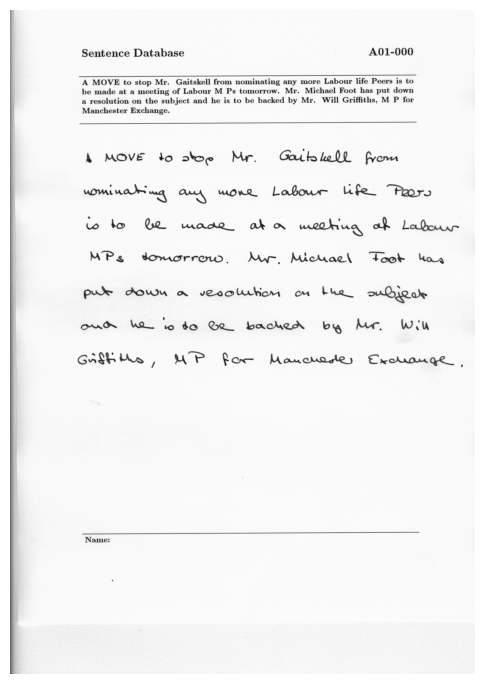

In [67]:
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [68]:
reference = """
Sentence Database A01-000

A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for
Manchester Exchange.

A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for
Manchester Exchange.

Name:
""" #  store the desired text in the variable reference. 

In [69]:
transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ]
)

wer = jiwer.wer(
                reference,
                extracted_text,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )

print(f"Word Error Rate is:", wer)

Word Error Rate is: 0.5


The 0.5 error rate was expected, as only the typed section of the text was accurately detected, while the handwritten part suffered from significant misdetection.

## Tuning the Code

At this point, let's draw a box around each character detected by the pytesseract package to take a closer look at the source of the problem.

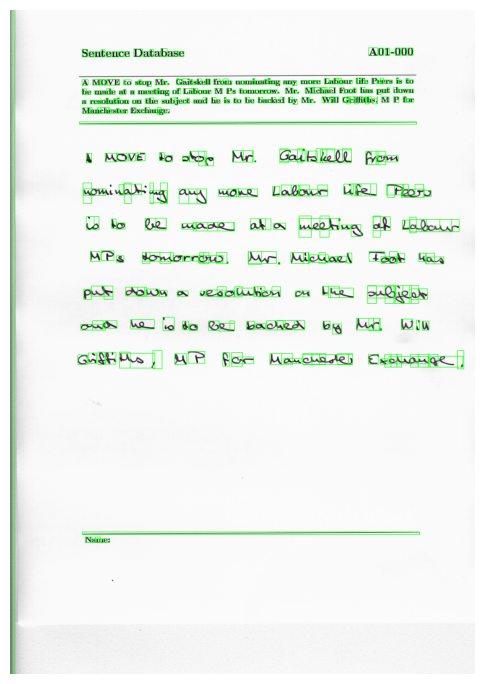

In [70]:
# Get the height, width, and channels of the original image
h, w, c = img.shape

# Make a copy of the original image to avoid modifying it
img_box = img.copy()

# Get the bounding boxes for the characters detected by pytesseract
boxes = pytesseract.image_to_boxes(img)

# Draw rectangles around each character detected
for b in boxes.splitlines():
    b = b.split(' ')
    img_box = cv2.rectangle(img_box, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# Display the image with the bounding boxes
plt.figure(figsize=(6, 10))
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.axis('off')
plt.show()

In general, each character is well identified, which reveals that the issue mainly lies in recognizing each character individually. In the next step, we will iterate over all possible PSM values and check their effect on the Word Error Rate (WER).

In [71]:
# List of OEM and PSM values to iterate through
psm_values = [i for i in range(1, 14) if i != 2]

# Iterate through all combinations of OEM and PSM

# Iterate through the PSM values
for ps in psm_values:
    # Set the Tesseract configuration using PSM and OEM (fixed OEM 3 in this case)
    custom_config = f"--oem 3 --psm {ps}"
    
    # Extract text using the current configuration
    extracted_text = pytesseract.image_to_string(img, config=custom_config)
    
    # Calculate WER for the current extracted text
    wer = jiwer.wer(
        reference,
        extracted_text,
        truth_transform=transforms,
        hypothesis_transform=transforms,
    )
    
    # Print the WER for this combination of OEM and PSM
    print(f"OEM: 3, PSM: {ps}, Word Error Rate: {wer}")

OEM: 3, PSM: 1, Word Error Rate: 0.41
OEM: 3, PSM: 3, Word Error Rate: 0.41
OEM: 3, PSM: 4, Word Error Rate: 0.41
OEM: 3, PSM: 5, Word Error Rate: 0.99
OEM: 3, PSM: 6, Word Error Rate: 0.5
OEM: 3, PSM: 7, Word Error Rate: 0.99
OEM: 3, PSM: 8, Word Error Rate: 0.99
OEM: 3, PSM: 9, Word Error Rate: 1.0
OEM: 3, PSM: 10, Word Error Rate: 1.0
OEM: 3, PSM: 11, Word Error Rate: 0.52
OEM: 3, PSM: 12, Word Error Rate: 0.52
OEM: 3, PSM: 13, Word Error Rate: 0.99


The best performance was achieved with **PSM 1**, **PSM 3**, and **PSM 4**. After reviewing the documentation, we found the following:

- **PSM 1: Automatic page segmentation with OSD**  
  Automatically segments the page while detecting both orientation and script. This mode is particularly useful for complex layouts where the orientation is unknown.

- **PSM 3: Fully automatic page segmentation (no OSD)**  
  Tesseract automatically segments the image into blocks of text, such as paragraphs or columns, but does not detect the orientation or script. Suitable for structured text without orientation issues.

- **PSM 4: Assume a single column of text of variable sizes**  
  Assumes the image contains a single column of text, with possible variations in font size. This mode is useful for documents with a straightforward single-column layout.

However, the overall error remains high for the handwritten portion of the text. Therefore, further tuning is required to explore other possible improvements.

Although the data we are using has already been preprocessed, we will apply several filters to determine if any further enhancements can be achieved.

In [99]:
# save and display the output of the best option
extracted_text_3_1 = pytesseract.image_to_string(img, config=r'--oem 3 --psm 1')
print(extracted_text_3_1)

Sentence Database A01-000

A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for
Manchester Exchange.

k MOVE to stoe Mr. Gariblkedl from

KO HOI wae Oud WOWR Lofowr Ufle_ “Poors

wo to B2 wade aka medhua af Le Doar
MPs toucrreoro, My, Michael Fook Kay
pre Aown a vesolition on the sudiody
Onr Wo do Va. backeR by Mer. Wit

GafhUs , WP Ror Moncrodes Cerorrange _

Name:




In [84]:
# Define the reference and transforms (assuming these are defined globally or passed as arguments)
#reference = reference
transforms = jiwer.Compose(
    [
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords(),
    ]
)

# Define a function that calculates and displays the Word Error Rate (WER) after applying the filter
def calculate_print_wer(image, filter_string):
    extracted_text = pytesseract.image_to_string(image, config=r'--oem 3 --psm 1')
    # Calculate the Word Error Rate (WER)
    wer = jiwer.wer(
        reference,
        extracted_text,
        truth_transform=transforms,
        hypothesis_transform=transforms,
    )
    
    # Print the WER result with the filter string
    print(f"Word Error Rate with {filter_string}: {wer}")

# Get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Example usage
gray = get_grayscale(img)  # Ensure `image` is defined
calculate_print_wer(gray, 'gray filter')

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
noise = remove_noise(gray)
calculate_print_wer(noise, 'gray and remove noise filter')

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
calculate_print_wer(thresh, 'gray and thresholding filter')

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
dilation = dilate(gray)
calculate_print_wer(dilation, 'gray and dilation filter')

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)
erosion = erode(gray)
calculate_print_wer(erosion, 'gray and erosion filter')

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
open = opening(gray)
calculate_print_wer(open, 'gray and opening filter')

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)
can = canny(gray)
calculate_print_wer(can, 'gray and canny filter')


Word Error Rate with gray filter: 0.41
Word Error Rate with gray and remove noise filter: 0.44
Word Error Rate with gray and thresholding filter: 0.4
Word Error Rate with gray and dilation filter: 0.52
Word Error Rate with gray and erosion filter: 0.41
Word Error Rate with gray and opening filter: 0.41
Word Error Rate with gray and canny filter: 0.56


In [103]:
thresh = thresholding(gray)
extracted_text_3_1_gray_thr = pytesseract.image_to_string(thresh, config=r'--oem 3 --psm 1')
print(extracted_text_3_1_gray_thr)

Sentence Database A01-000

A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for
Manchester Exchange.

hk MOVE to stoe Mr. Garibked from

HOW OSE wae And OWL LoBowr Ule_ “Poors

wo to WB wade, aka medina af Lao
MPs tdouocrreonto, My, Michael Fook Uoay
pale Aown a vesolutionn on bua sudiody
Onr Wo do Va. backeHR by Mr, Wit

Gafhies , WP Ror Mancrmdes, Crorronge _

Name:




Applying the Threshold filter after the grayscale filter resulted in only a slight improvement in WER.

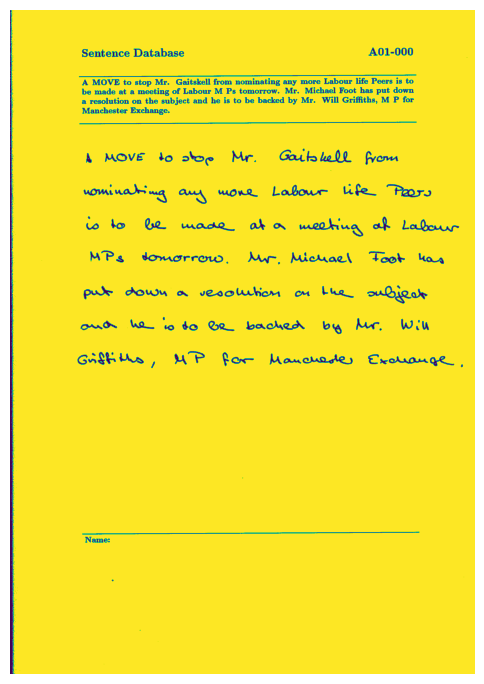

In [85]:
plt.figure(figsize=(6,10))
plt.imshow(thresh)
plt.axis('off')
plt.show()

In the next step, we will try to rely on detecting whole words and recognizing them completely, rather than processing each character separately. This approach aims to improve the accuracy of our code. To implement this, we will use PSM options 8 and 9, which are designed for word-level detection. However, in this case, we need to load the images of each word separately from our database.

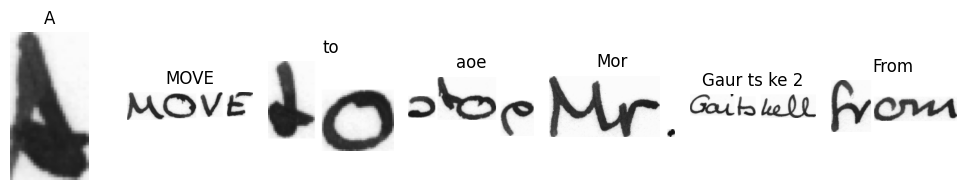

In [116]:
words = [
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-00.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-01.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-02.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-03.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-04.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-05.png'),
    cv2.imread('../../words/a01/a01-000u/a01-000u-00-06.png'),
]

# Set the figure size and number of subplots (one per word image)
plt.figure(figsize=(10, 2))  # Adjusted the overall figure size (10 inches wide and 2 inches tall)

# Iterate over each word, extract the text, and display the image
for i, word in enumerate(words):
    plt.subplot(1, len(words), i+1)  # Create subplots, one per word
    plt.imshow(word)
    plt.axis('off')

    # Extract text using pytesseract
    extracted_text = pytesseract.image_to_string(word, config=r'--oem 3 --psm 8')
    
    # Display the prediction as the title of each subplot
    plt.title(extracted_text.strip(), fontsize=12)  # Increased the font size for readability

# Show all the subplots
plt.tight_layout()
plt.show()



In [129]:
# Path to the folder containing the word images
folder_path = '../../words/a01/a01-000u/'

# Initialize an empty list to hold the extracted text
full_text = []

# Iterate over all files in the folder
for file_name in sorted(os.listdir(folder_path)):
    # Check if the file is a PNG image
    if file_name.endswith('.png'):
        # Read the image
        img_path = os.path.join(folder_path, file_name)
        word_image = cv2.imread(img_path)

        # Apply pytesseract OCR to extract the text
        extracted_text = pytesseract.image_to_string(word_image, config=r'--oem 3 --psm 8')

        # Append the extracted text to the list, stripping any extra whitespace
        full_text.append(extracted_text.strip())

# Join the list of words to form the complete text
complete_text = ' '.join(full_text)

# Print the complete text
print("Complete text:", complete_text)

Complete text: A MOVE to aoe Mor Gaur ts ke 2 From OVAL OD aa aoa VAD KQ_ Lahourr Life. FRO. en Lo Q,Q_ UAAALD or OA, wrk wa ol. La owuir Mere SONU FOILO a wr. Ma ‘ohxwaz\ ‘4 a0+ ha, put Qaudu cr. vege brilbon CmA Lue DA Qi2 Ve +>» On LQ wo a. C5Q__ packer bw Luc W oA GA LH Mos / i R On ML ancmahe j Co ne AKO Qe &


In [127]:
#Create a reference file that contain the correct text only once.
reference_2 = """ A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for Manchester Exchange."""

In [130]:
wer = jiwer.wer(
                reference_2,
                complete_text,
                truth_transform=transforms,
                hypothesis_transform=transforms,
            )

print(f"Word Error Rate is:", wer)

Word Error Rate is: 1.3137254901960784


The Word Error Rate (WER) remains very high and appears to be getting worse. Trying PSM 9 did not show satisfying results either.